In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy import sparse, fftpack
from scipy.sparse import linalg as splinalg

In [17]:
def extrema_grid(N):
    n = np.arange(start=0, stop=N, step=1)
    return np.cos(np.pi * n/(N-1))


def cheb(x):
    N = np.shape(x)[-1]
    return 1/(N-1) * fftpack.dct(x, axis=-1, type=1)


def icheb(x):
    return  1/2 * fftpack.idct(x, axis=-1, type=1)

**1.1**

$\frac{A_{n+1} - A_n}{h} = A_{n+1} + (1 + i b) \frac{\partial^2 A_{n+1}}{\partial x^2} - (1 + i c)|A_n|^2 A_n$

$\left(\frac{1}{h} - 1 - (1 + i b)\frac{\partial^2}{∂ x^2}\right) A_{n+1} = \frac{1}{h} A_n - (1 + i c)|A_n|^2 A_n$

**1.2**

I remap the domain according to,

$y = 2 \left( \frac{x}{L} - \frac{1}{2}\right)$

Such that,

$\frac{\partial A}{\partial x} = \frac{2}{L} \frac{\partial A}{\partial y}$

$\frac{\partial^2 A}{\partial x^2} = \left( \frac{2}{L} \right)^2 \frac{\partial^2 A}{\partial y^2}$

The above equation is then,

$\left(\frac{1}{h} - 1 - (1 + i b) \left( \frac{2}{L} \right)^2  \frac{\partial^2}{∂ y^2}\right) A_{n+1} = \frac{1}{h} A_n - (1 + i c)|A_n|^2 A_n$



My cheb implimentation follows these notes:

https://www.math.ucdavis.edu/~bremer/classes/fall2018/MAT128a/lecture10.pdf

Note that my first and last coeffecients have a factor of 1/2, which i must account for in the differentiation and basis change matricies.

In [18]:
def differentiation_matrix(lamb, N):
    const = (2 ** (lamb - 1)) * np.math.factorial(lamb - 1)
    row = const * (np.arange(start=0, stop=N-lamb, step=1) + lamb)
    return sparse.diags([row], [lamb])


def conversion_matrix(alpha, N):
    if alpha > 0:
        row = np.arange(start=1, stop=N, step=1)
        row = np.concatenate([[1], alpha/(alpha + row)])
        return sparse.diags([row, -1 * row[2:]], [0, 2])
    elif alpha == 0:
        row = 1/2 * np.ones(N)
        return sparse.diags([row, -1 * row[2:]], [0, 2])
    raise ValueError("alpha must be non-negative")

In [19]:
def test_ultraspherical_differentiation():
    N = 2**6
    grid = extrema_grid(N)
    quad_coeff = np.random.uniform(-1, 1)
    y = quad_coeff * grid**3 + np.sin(grid) + np.tan(grid)
    dy = 3 * quad_coeff * grid**2 + np.cos(grid) + 1/np.cos(grid)**2
    ddy = 6 * quad_coeff * grid - np.sin(grid) + 2 * np.tan(grid)/np.cos(grid)**2
    y_cheb = cheb(y)
    d_mat = differentiation_matrix(1, N)
    dy_ultra = d_mat.dot(y_cheb)
    conv_mat = conversion_matrix(0, N)
    dy_ultra_true = conv_mat.dot(cheb(dy))
    np.testing.assert_allclose(dy_ultra, dy_ultra_true, atol=1e-7)
    dd_mat = differentiation_matrix(2, N)
    ddy_ultra = dd_mat.dot(y_cheb)
    conv_mat_2 = conversion_matrix(1, N)
    ddy_ultra_true = conv_mat_2.dot(conv_mat.dot(cheb(ddy)))
    np.testing.assert_allclose(ddy_ultra, ddy_ultra_true, atol=1e-7)

In [20]:
test_ultraspherical_differentiation()

In [21]:
def construct_lhs(h, b, L, N):
    raw_lhs = (1/h - 1) * conversion_matrix(1,N).dot(conversion_matrix(0, N))\
              - (1 + 1j * b) * ((2/L)**2) * differentiation_matrix(2, N)
    idx = np.arange(start=0, stop=N, step=1)
    raw_lhs[-2, :] = (-1) ** idx
    raw_lhs[-1, :] = 1
    return raw_lhs

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


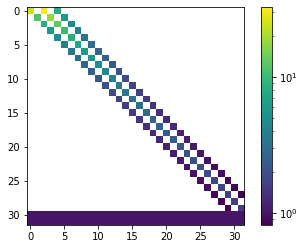

In [22]:
N = 32
h = 0.02
L = 300
b = 0.5
c = -1.76

lhs = construct_lhs(h, b, L, N)

fig, axs = plt.subplots()
im = axs.imshow(np.abs(lhs.todense()), norm=LogNorm())
fig.colorbar(im)
plt.show()

With the exception of the lower two rows (which I added directly to deal with the boundary conditions), the matrix is banded, with the three bands living in the upper triangle. This makes sense, as the differentiation matrix has this form, and the product of the conversion matricies will also have this form.

**1.3**

35.1 µs ± 975 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
112 µs ± 2.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
411 µs ± 7.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.37 ms ± 73.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16 ms ± 70.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.9 ms ± 449 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
176 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


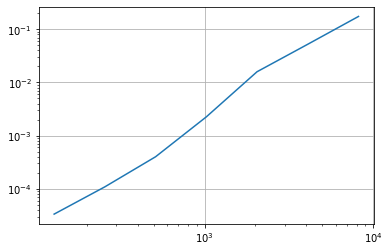

In [14]:
N_vals = 2 ** np.arange(start=7, stop=14, step=1)
t_direct = %timeit -o

times = []
for N in N_vals:
  rhs = np.random.uniform(-1, 1, N)
  lhs = construct_lhs(h, b, L, N)
  lu = splinalg.splu(lhs)
  time = %timeit -o lu.solve(rhs)
  times.append(time.best)

fig, axs = plt.subplots()
axs.plot(N_vals, times)
axs.set_xscale("log")
axs.set_yscale("log")
axs.grid(True)

The scaling is $N^2$. This makes sense, as the LU decomposition of the matrix with the densely filled bottom two rows is dense, and therefore the solve should have quadratic complexity.

In [23]:
N = 128
rhs = np.random.uniform(-1, 1, N)
lhs = construct_lhs(h, b, L, N)
lu = splinalg.splu(lhs)
lu_t = splinalg.splu(lhs.transpose())
soln = lu.solve(rhs)
soln_t = lu_t.solve(rhs, trans="T")
np.testing.assert_allclose(soln, soln_t)


/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


14.5 µs ± 86.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20.8 µs ± 554 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
33 µs ± 525 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
59.9 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
117 µs ± 775 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
216 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
405 µs ± 5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


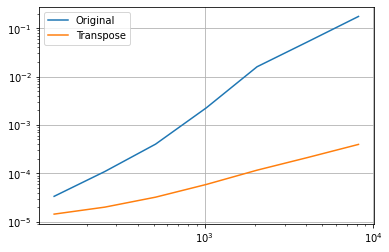

In [16]:
N_vals = 2 ** np.arange(start=7, stop=14, step=1)
t_direct = %timeit -o

times_t = []
for N in N_vals:
  rhs = np.random.uniform(-1, 1, N)
  lhs = construct_lhs(h, b, L, N)
  lu = splinalg.splu(lhs.T)
  time = %timeit -o lu.solve(rhs, trans="T")
  times_t.append(time.best)

fig, axs = plt.subplots()
axs.plot(N_vals, times, label="Original")
axs.plot(N_vals, times_t, label="Transpose")
axs.set_xscale("log")
axs.set_yscale("log")
axs.legend()
axs.grid(True)

The new solver has optimal scaling. This is because the LU decomposition is sparse in this case.

**1.4**

In [25]:
def construct_rhs_cheb(a_cheb, h, c):
    a_grid = icheb(a_cheb)
    rhs_grid = 1/h * a_grid - (1 + 1j * c) * np.abs(a_grid)**2 * a_grid
    rhs_cheb = cheb(rhs_grid)
    return rhs_cheb

def ultraspherical_rhs_generator(N):
  conv_mat_0 = conversion_matrix(0, N)
  conv_mat_1 = conversion_matrix(1, N)

  def construct_rhs_ultra(a_cheb, h, c):
      rhs_cheb = construct_rhs_cheb(a_cheb, h, c)
      converted = conv_mat_1.dot(conv_mat_0.dot(rhs_cheb))
      converted[..., -2:] = 0
      return converted

  return construct_rhs_ultra

In [32]:
def test_rhs():
    N = 32
    h = 0.02
    c = 0.5
    a_grid = np.random.uniform(-1, 1, N)
    rhs_grid = 1/h * a_grid - (1 + 1j * c) * np.abs(a_grid)**2 * a_grid
    rhs_cheb = cheb(rhs_grid)
    rhs_cheb_test = construct_rhs_cheb(cheb(a_grid), h, c)
    np.testing.assert_allclose(rhs_cheb, rhs_cheb_test)


In [33]:
test_rhs()

118 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
78.8 µs ± 619 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
135 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
164 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
397 µs ± 9.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
617 µs ± 145 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.22 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.67 ms ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.61 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.9 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
171 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


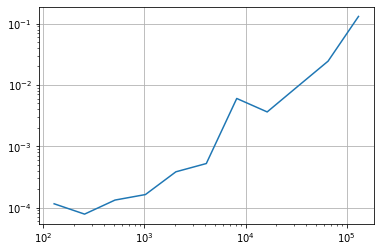

In [36]:
N_vals = 2 ** np.arange(start=7, stop=18, step=1)
t_direct = %timeit -o

times = []
for N in N_vals:
  rhs_generator = ultraspherical_rhs_generator(N)
  a_prev = np.random.uniform(-1, 1, N)
  time = %timeit -o rhs_generator(a_prev, h, c)
  times.append(time.best)

fig, axs = plt.subplots()
axs.plot(N_vals, times)
axs.set_xscale("log")
axs.set_yscale("log")
axs.grid(True)

The scaling is O(N) -like, which is what I would expect given I am only doing FFTs and multiplying grids.

**1.5**

In [37]:
def solve_iteratively(n_iter, N, h, b, c, L, a_0_grid, save_every=10):
    lhs = construct_lhs(h, b, L, N)
    lhs_lu = splinalg.splu(lhs.T)
    rhs_generator = ultraspherical_rhs_generator(N)
    a_0_cheb = cheb(a_0_grid)
    solns = []
    this_soln_cheb = a_0_cheb
    for i in range(n_iter):
        this_soln_cheb = lhs_lu.solve(rhs_generator(this_soln_cheb, h, c), trans="T")
        if not i % save_every:
            this_soln_grid = icheb(this_soln_cheb)
            solns.append(this_soln_grid)
    return np.array(solns)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


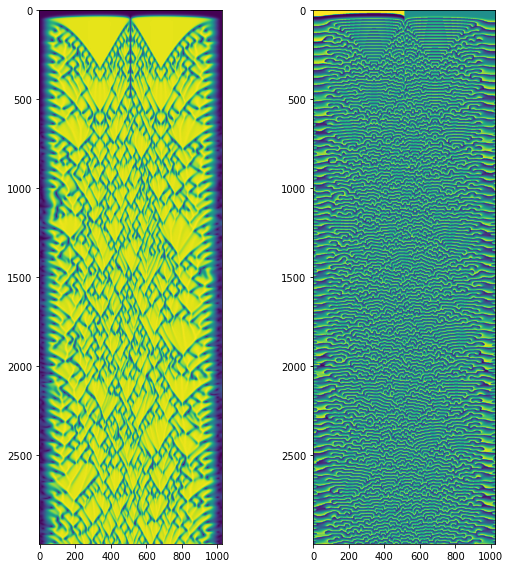

In [40]:
N = 1024
h = 0.02
L = 300
b = 0.5
c = -1.76
n_iter = 30000


grid = extrema_grid(N)
grid_x = 1/2 * L * (grid + 1)
a_o_grid = 10**-3 * np.sin(2 * np.pi * grid_x/L)

solns = solve_iteratively(n_iter, N, h, b, c, L, a_o_grid)

fig, axs = plt.subplots(ncols=2, figsize=(8,8))
axs[0].imshow(np.abs(solns))
axs[1].imshow(np.arctan2(np.imag(solns), np.real(solns)))
fig.tight_layout()


**1.6**

I think $\alpha = 2$ would be required to dealias in this case. The $3/2$ rule works for quadratic nonlinearities, but this cubic nonlinearity will have higher harmonics that we will need to deal with.